<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-modulation,-modulate-and-demodulate-data" data-toc-modified-id="Define-modulation,-modulate-and-demodulate-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define modulation, modulate and demodulate data</a></span></li></ul></div>

<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test basic digital modulation functionalities

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.comm.metrics import fastBERcalc, theoryBER
from optic.models.channels import awgn
from optic.dsp.core import pnorm, signal_power
from optic.plot import pconst
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%load_ext autoreload
%autoreload 2

## Define modulation, modulate and demodulate data

BER = 0.00e+00
SNR = 25.00 dB
SNR(est) = 25.01 dB
BER(theory) = 6.66e-16


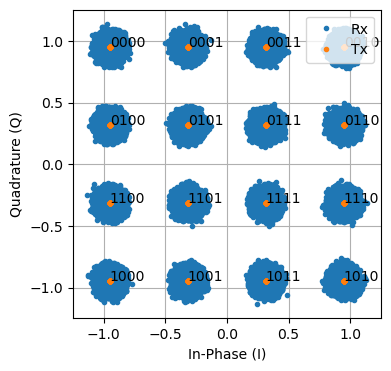

In [4]:
# Run AWGN simulation 
SNRdB = 25 # SNR 
M      = 16  # order of the modulation format
constType = 'qam' # 'qam', 'psk', 'apsk', 'pam' or 'ook'

# generate random bits
bits = np.random.randint(2, size = int(np.log2(M)*1e6))

# Map bits to constellation symbols
symbTx = modulateGray(bits, M, constType)

# normalize symbols energy to 1
symbTx = pnorm(symbTx)

# AWGN    
EbN0dB = SNRdB - 10*np.log10(np.log2(M))
symbRx = awgn(symbTx, SNRdB)
    
# BER calculation (hard demodulation)
BER, _, SNRest = fastBERcalc(symbRx, symbTx, M, constType)
print('BER = %.2e'%BER)
print('SNR = %.2f dB'%SNRdB)
print('SNR(est) = %.2f dB'%SNRest)

if constType in ['qam','psk','pam']:
    print('BER(theory) = %.2e'%theoryBER(M, EbN0dB, constType))

plt.figure(figsize=(4,4))
plt.plot(symbRx.real, symbRx.imag,'.', label='Rx')
plt.plot(symbTx.real, symbTx.imag,'.', label='Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)')
plt.ylabel('Quadrature (Q)')
plt.legend(loc='upper right');
plt.grid()


# plot modulation bit-to-symbol mapping
constSymb = grayMapping(M, constType)             # Gray constellation mapping
bitMap = demodulateGray(constSymb, M, constType)  # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = signal_power(constSymb)                      # mean symbol energy

for ind, symb in enumerate(constSymb/np.sqrt(Es)):
    bitMap[ind,:]
    plt.annotate(str(bitMap[ind,:])[1:-1:2], xy = (symb.real, symb.imag))

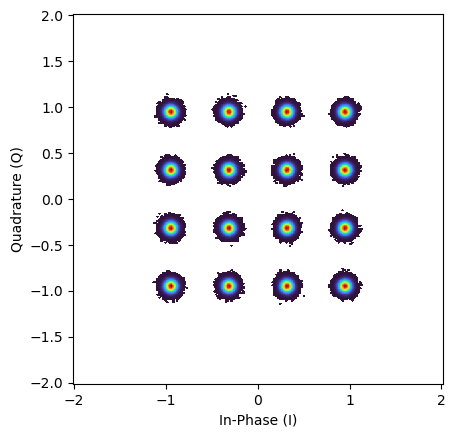

In [5]:
pconst(symbRx, whiteb=True, R=1.5*np.max(np.abs(constSymb/np.sqrt(Es))));

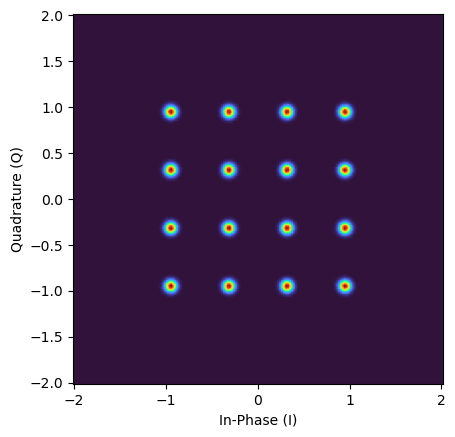

In [6]:
pconst(symbRx, whiteb=False, R=1.5*np.max(np.abs(constSymb/np.sqrt(Es))));

In [7]:
from numba import njit

@njit
def detector(r, σ2, constSymb, px=None, rule='MAP'):
    """
    Perform symbol detection using either the MAP (Maximum A Posteriori) or ML (Maximum Likelihood) rule.

    Parameters:
        r (ndarray): The received signal.
        σ2 (float): The noise variance.
        constSymb (ndarray): The constellation symbols.
        px (ndarray, optional): The prior probabilities of each symbol. If None, uniform priors are assumed.
        rule (str, optional): The detection rule to use. Either 'MAP' (default) or 'ML'.

    Returns:
        tuple: A tuple containing:
            - ndarray: The detected symbols.
            - ndarray: The indices of the detected symbols in the constellation.

    """
    if px is None or rule == 'ML':
        px = 1 / constSymb.size * np.ones(constSymb.size)
           
    decided = np.zeros(r.size, dtype=np.complex64) 
    indDec = np.zeros(r.size, dtype=np.int64) 
    π = np.pi  
    
    if rule == 'MAP':
        for ii, ri in enumerate(r): # for each received symbol        
            log_probMetric = np.zeros(constSymb.size)

            # calculate MAP probability metric        
            # calculate log(P(sm|r)) = log(p(r|sm)*P(sm)) for m= 1,2,...,M
            log_probMetric = - np.abs(ri - constSymb)**2 / σ2 + np.log(px)

            # find the constellation symbol with the largest P(sm|r)       
            indDec[ii] = np.argmax(log_probMetric)

            # make the decision in favor of the symbol with the largest metric
            decided[ii] = constSymb[indDec[ii]]
            
    elif rule == 'ML':      
        for ii, ri in enumerate(r): # for each received symbol        
            distMetric = np.zeros(constSymb.size)        
            # calculate distance metric   

            # calculate |r-sm|**2, for m= 1,2,...,M
            distMetric = np.abs(ri - constSymb)**2

            # find the constellation symbol with the smallest distance metric       
            indDec[ii] = np.argmin(distMetric)

            # make the decision in favor of the symbol with the smallest metric
            decided[ii] = constSymb[indDec[ii]]
    else:
        print('Detection rule should be either MAP or ML')
        
    
    return decided, indDec

In [62]:
from optic.utils import dB2lin

SNR = 20
σ2 = 1/dB2lin(SNR)

In [68]:
d = 3
x_min, x_max = min(constSymb.real)-d, max(constSymb.real)+d
y_min, y_max = min(constSymb.imag)-d, max(constSymb.imag)+d

h = 0.005
gI, gQ = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

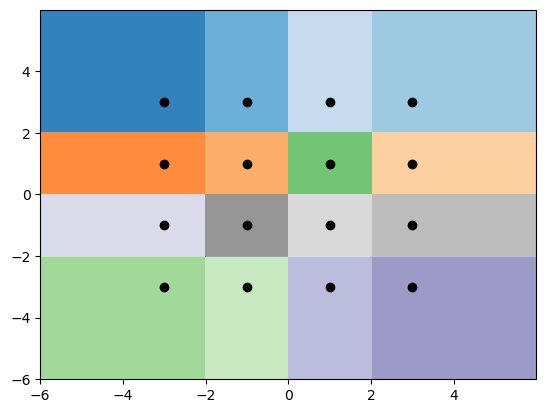

In [69]:
r = gI.ravel() + 1j*gQ.ravel()
dec, pos = detector(r, σ2, constSymb, rule='MAP') # detector

# Put the result into a color plot
Z = pos.reshape(gI.shape)
fig, ax = plt.subplots()
ax.contourf(gI, gQ, Z, 32, cmap=plt.cm.tab20c);
ax.plot(constSymb.real, constSymb.imag,'ko');